In [25]:
import time
import torch
import numpy as np
import networkx as nx
import collections
import matplotlib.pyplot as plt
from data.gene_graphs import GeneManiaGraph, RegNetGraph
from scipy import sparse
import joblib 
import sklearn.cluster
import scipy.cluster
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import ward, fcluster
from sklearn.cluster import AgglomerativeClustering
#torch.cuda.set_device(1)

In [2]:

def show_degree(G):  
    degree_sequence = sorted([d for n, d in G.degree()], reverse=True)  # degree sequence
    # print "Degree sequence", degree_sequence
    degreeCount = collections.Counter(degree_sequence)
    deg, cnt = zip(*degreeCount.items())

    fig, ax = plt.subplots()
    plt.bar(deg, cnt, width=0.80, color='b')

    plt.title("Degree Histogram")
    plt.ylabel("Count")
    plt.xlabel("Degree")
    ax.set_xticks([d + 0.4 for d in deg])
    ax.set_xticklabels(deg)

    # draw graph in inset
    plt.axes([0.4, 0.4, 0.5, 0.5])
    Gcc = sorted(nx.connected_component_subgraphs(G), key=len, reverse=True)[0]
    pos = nx.spring_layout(G)
    plt.axis('off')
    nx.draw_networkx_nodes(G, pos, node_size=20)
    nx.draw_networkx_edges(G, pos, alpha=0.4)

    plt.show()


In [3]:
rand = torch.rand(10,10)
symmetric = torch.mm(rand, rand.t()) # make symmetric positive definite
adj = torch.ByteTensor(symmetric>symmetric.mean())


In [4]:
print(adj)

tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 0, 1, 1, 0, 0, 0, 0],
        [1, 1, 0, 1, 1, 1, 1, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 1, 1, 1, 1, 0, 1, 0],
        [1, 1, 0, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 0, 0, 1, 0, 1, 0, 0, 0],
        [1, 1, 0, 0, 1, 1, 1, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=torch.uint8)


In [13]:
gene_graph = GeneManiaGraph()
adj = np.array(nx.to_numpy_matrix(gene_graph.nx_graph))

Torrent name: genemania.pkl, Size: 9.61MB
Checking for pieces on disk: |██████████████████████████████████████████████████| 100.0% 
Found 294 finished pieces out of 294 total pieces.
Found dataset at /Users/martinweiss/.academictorrents-datastore/genemania.pkl


In [6]:
clusters = AgglomerativeClustering(n_clusters=4, affinity='euclidean', memory='.cache', connectivity=(adj.numpy() > 0.).astype(bool), compute_full_tree='auto', linkage='ward').fit_predict(adj.numpy())
print(clusters)


[0 0 2 0 0 0 0 3 0 1]


In [7]:
new_ids = []
biggest_cluster = np.argmax(np.bincount(clusters))
for i, cluster in enumerate(clusters):
    if cluster != biggest_cluster:
        new_ids.append(i)
new_adj = adj[new_ids, :][:, new_ids]

In [10]:
new_adj

tensor([[1, 0, 0],
        [0, 0, 0],
        [0, 0, 0]], dtype=torch.uint8)

/Users/martinweiss/code/academic/conv-graph/venv/lib/python3.5/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


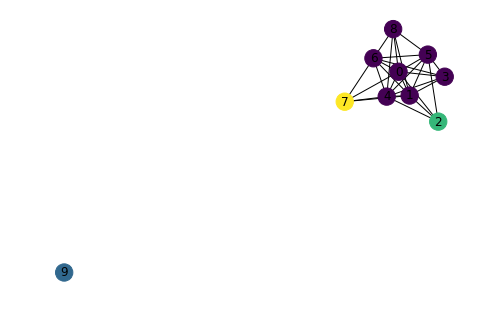

In [11]:
G = nx.from_numpy_matrix(np.matrix(adj)) 
nx.draw(G, node_color=clusters, with_labels=True)

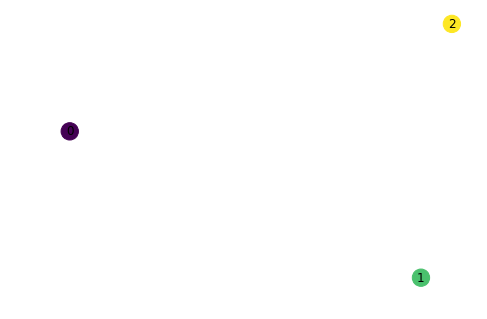

In [12]:
G = nx.from_numpy_matrix(np.matrix(new_adj)) 
nx.draw(G, node_color=new_ids, with_labels=True)

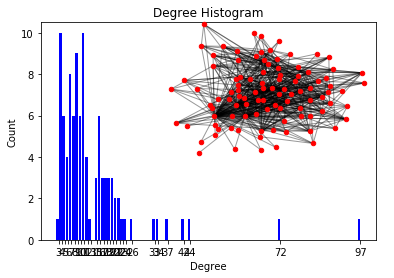

In [98]:
G = nx.from_numpy_matrix(np.matrix(adj))
show_degree(G)

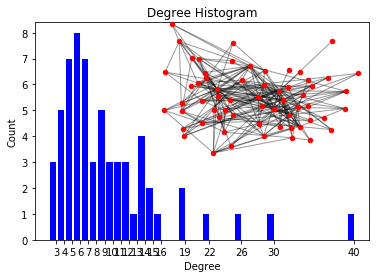

In [96]:
G = nx.from_numpy_matrix(np.matrix(new_adj))
show_degree(G)

In [336]:
## All the edge weights are really small. They are actually confidence intervals. Also, it's a sparse graph

Torrent name: genemania.pkl, Size: 9.61MB


In [51]:
def bucket_weights(adj, bins):
    labels = ["".join(str(labels[0]) + "-" + str(round(labels[1], 1))) for labels in zip(bins, bins + 0.1)]
    labels[0] = "(" + labels[0]

    results = []
    nodes = {}
    for x in bins:
        subgraph = ((adj > x) & (adj <= x + 0.1))  
        results.append(subgraph.sum())
        nodes[x] = subgraph
    return results, labels, nodes

In [600]:
gene_graph = GeneManiaGraph()
genemania_adj = np.asarray(nx.to_numpy_matrix(gene_graph.nx_graph))

Torrent name: genemania.pkl, Size: 9.61MB


In [783]:
bins = np.array([round(x, 1) for x in np.arange(0., 1., 0.1)])
genemania_results, genemania_labels, nodes = bucket_weights(genemania_adj, bins)

In [788]:
len(genemania_labels)

10

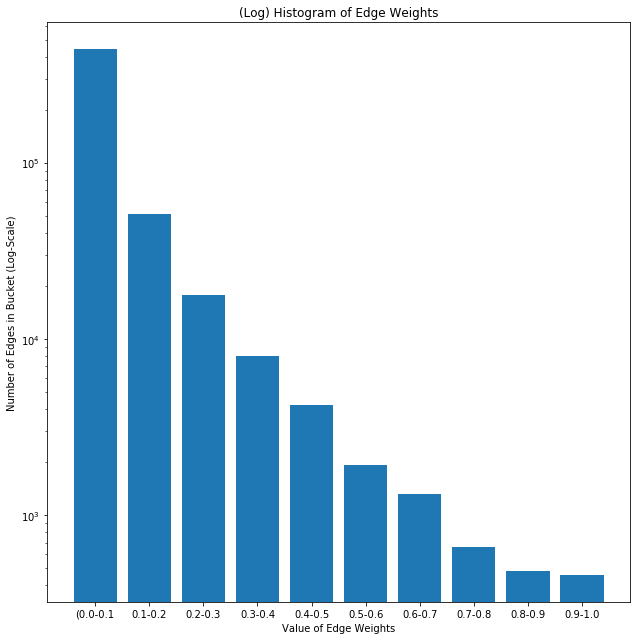

In [794]:
plt.figure(figsize=(9, 9))

plt.bar(x=genemania_labels, height=genemania_results, log=1)
plt.title("(Log) Histogram of Edge Weights")
plt.xlabel("Value of Edge Weights")
plt.ylabel("Number of Edges in Bucket (Log-Scale)")
plt.xlim=1.0

plt.tight_layout()
plt.show()

In [26]:
regnet = RegNetGraph()

Torrent name: regnet.pkl, Size: 8.81MB
Checking for pieces on disk: |██████████████████████████████████████████████████| 100.0% 
Found 269 finished pieces out of 269 total pieces.
Found dataset at /Users/martinweiss/.academictorrents-datastore/regnet.pkl


In [65]:
nodes, one_gene_adj = regnet.first_degree("RPL3")
print("num_edges: " + str((one_gene_adj>0.).sum()/2))

num_edges: 1007.0


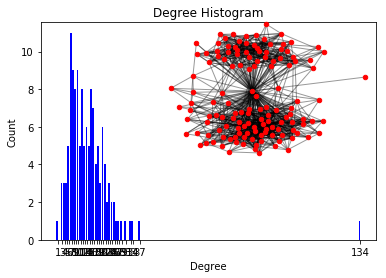

In [66]:
G = nx.from_numpy_matrix(np.matrix(one_gene_adj))
show_degree(G)

In [78]:
temp = np.array(nx.to_numpy_matrix(regnet.nx_graph))/np.array(nx.to_numpy_matrix(regnet.nx_graph)).max()
bins = np.array([round(x, 1) for x in np.arange(0., 1., 0.1)])
regnet_results, regnet_labels, nodes = bucket_weights(temp, bins)

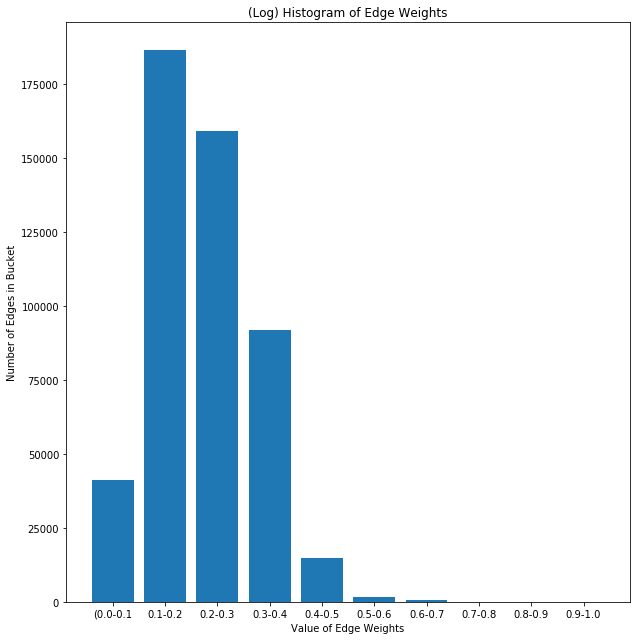

In [79]:
plt.figure(figsize=(9, 9))

plt.bar(x=regnet_labels, height=regnet_results)
plt.title("(Log) Histogram of Edge Weights")
plt.xlabel("Value of Edge Weights")
plt.ylabel("Number of Edges in Bucket")
plt.xlim=1.0

plt.tight_layout()
plt.show()

/Users/martinweiss/code/academic/conv-graph/venv/lib/python3.5/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


Clustered by SKLearn Agglomerative Clustering


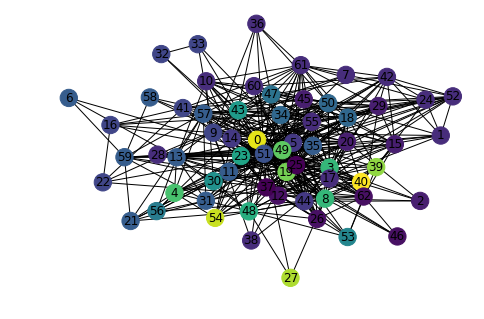

In [48]:
clusters = AgglomerativeClustering(n_clusters=25, affinity='euclidean', memory='/tmp', connectivity=one_gene_adj, compute_full_tree='auto', linkage='ward').fit_predict(one_gene_adj)
G = nx.from_numpy_matrix(np.matrix(one_gene_adj)) 
nx.draw(G, node_color=clusters, with_labels=True)
print("Clustered by SKLearn Agglomerative Clustering")


In [16]:
clusters

array([23,  0, 15,  0,  0,  0,  0, 18, 17,  0, 12, 21, 22,  0, 16, 14,  0,
       19,  0, 24,  0,  0,  7,  0,  1, 13, 11,  6,  0,  0,  8,  0,  5,  0,
        0,  2, 20,  3,  9,  0,  0,  0,  0,  0,  0,  0, 10,  0,  4,  1])

In [17]:
new_clusters = []
biggest_cluster = np.argmax(np.bincount(clusters))
for i, cluster in enumerate(clusters):
    if cluster != biggest_cluster:
        new_clusters.append(i)


In [930]:
new_clusters

[0,
 2,
 7,
 8,
 10,
 11,
 12,
 14,
 15,
 17,
 19,
 22,
 24,
 25,
 26,
 27,
 30,
 32,
 35,
 36,
 37,
 38,
 46,
 48,
 49]

In [938]:
np.max(one_gene_adj[16], axis=0)

0.005900000222027302

Clustered by max edge weight


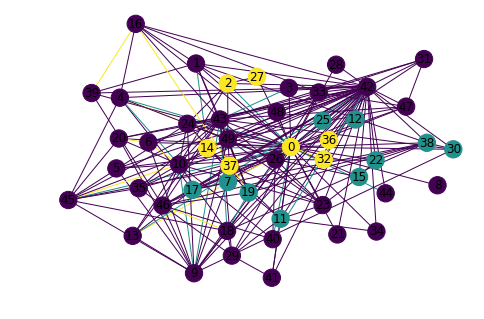

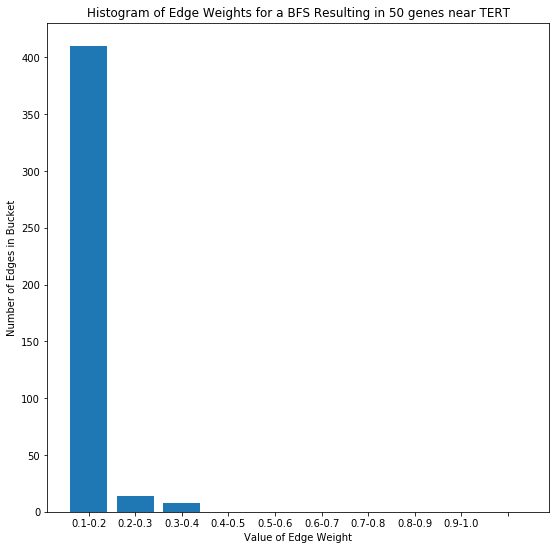

In [931]:
max_edge_weight = {}
i=0
for b in bins:
    for node1, node2 in np.argwhere(nodes[b]):
        max_edge_weight[node1] = int(10 * b)
        max_edge_weight[node2] = int(10 * b)
edge_colors = list((np.round(one_gene_adj[one_gene_adj.nonzero()].flatten(), 1) * 10).astype(int))[::2]
nx.draw(G, node_color=list(max_edge_weight.values()), edge_color=edge_colors, weights=weights, with_labels=True)
print("Clustered by max edge weight")


# Make the chart
bins = np.array([round(x, 1) for x in np.arange(0., 1., 0.1)])
one_gene_results, one_gene_labels, nodes = bucket_weights(one_gene_adj, bins)
plt.figure(figsize=(9, 9))
plt.bar(x=one_gene_labels, height=one_gene_results)
plt.title("Histogram of Edge Weights for a BFS Resulting in 50 genes near TERT")
plt.xlabel("Value of Edge Weight")
plt.ylabel("Number of Edges in Bucket")
plt.xticks(bins*10, labels=one_gene_labels[1:])
plt.show()

[5 0 0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 4
 1 0 0 0 0 0 0 0 0 0 0 0 0]


/Users/martinweiss/code/academic/conv-graph/venv/lib/python3.5/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


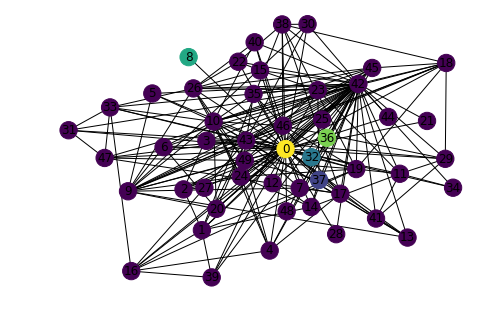

In [422]:
mirror = 1 - adj
clusters = AgglomerativeClustering(n_clusters=6, affinity='euclidean', memory='/tmp', connectivity=adj > 0., compute_full_tree='auto', linkage='ward').fit_predict(mirror)
print(clusters)
G = nx.from_numpy_matrix(np.matrix(adj)) 
nx.draw(G, node_color=clusters, with_labels=True)

[ 3  4  4 13  4 15 10  0 21  2  2  1 19  0  1  1  4  0  9 24 10 17  1  1
  6 16 18  4 14  1 23  0 11  0  1 10 20  1  8  4 22  1  3 12  7 10  9  0
  5  6]


/Users/martinweiss/code/academic/conv-graph/venv/lib/python3.5/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


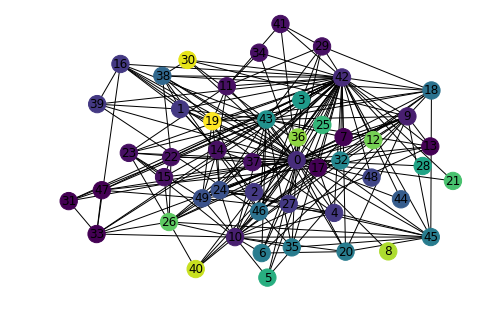

In [418]:
clusters = AgglomerativeClustering(n_clusters=25, affinity='euclidean', memory='/tmp', connectivity=adj > 0., compute_full_tree='auto', linkage='ward').fit_predict(adj > 0.)
print(clusters)
G = nx.from_numpy_matrix(np.matrix(adj)) 
nx.draw_spring(G, node_color=clusters, with_labels=True)

In [410]:
"PTP4A1', 'KLHL25', 'MTFMT', 'CRYGS', 'ITGAX', 'UMOD', 'MAPK9', 'ZNF382', 'BBS9', 'SLC41A1', 'LGALS2', 'TRMT44', 'FAM219A', 'CPSF3L', 'SH2D2A', 'TTC33', 'HSD11B1', 'CLEC12A', 'TUSC1', 'CD99L2', 'FAM105A', 'VASN', 'PSMD3', 'C1orf216"

"PTP4A1', 'KLHL25', 'MTFMT', 'CRYGS', 'ITGAX', 'UMOD', 'MAPK9', 'ZNF382', 'BBS9', 'SLC41A1', 'LGALS2', 'TRMT44', 'FAM219A', 'CPSF3L', 'SH2D2A', 'TTC33', 'HSD11B1', 'CLEC12A', 'TUSC1', 'CD99L2', 'FAM105A', 'VASN', 'PSMD3', 'C1orf216"

In [375]:
dist_adj = pdist(adj)

In [376]:
dist_adj

array([0.35910108, 0.30082571, 0.31920731, ..., 0.33999554, 0.34134374,
       0.20770223])

In [ ]:
adj

In [359]:
linkage = scipy.cluster.hierarchy.linkage(dist_adj)


In [362]:
z = ward(linkage)

In [363]:
cluster = fcluster(z, 18, criterion='distance')


In [143]:
len(set(cluster))


49

In [148]:
cluster

99

ValueError: 'c' argument has 99 elements, which is not acceptable for use with 'x' with size 100, 'y' with size 100.

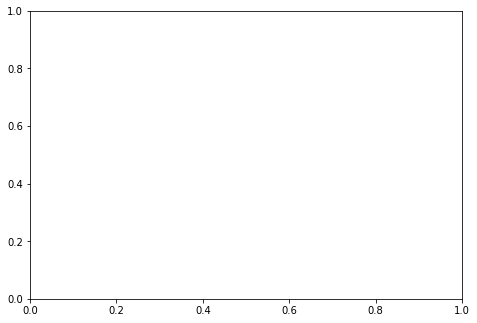

In [147]:
G = nx.from_numpy_matrix(np.matrix(adj)) 
nx.draw_shell(G, node_color=cluster.tolist(), with_labels=True)
